In [120]:
import pandas as pd
import numpy as np
import pyodbc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn import metrics 
from sklearn.tree import DecisionTreeClassifier

In [121]:
servername = 'SIU1\\SQLEXPRESS'

In [122]:
conn = pyodbc.connect('DRIVER={SQL SERVER};SERVER='+servername+';DATABASE=UnitedOutdoors; Trusted_Connection=yes')

In [123]:
orders = pd.read_sql_query('SELECT * FROM order_details', conn)
products = pd.read_sql_query('SELECT * FROM product', conn)
products = products[['product_productid', 'product_category']]
df = pd.merge(orders, products, on= 'product_productid')
df


C:\Users\tinep\AppData\Local\Temp\ipykernel_5728\1961401701.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  orders = pd.read_sql_query('SELECT * FROM order_details', conn)
C:\Users\tinep\AppData\Local\Temp\ipykernel_5728\1961401701.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  products = pd.read_sql_query('SELECT * FROM product', conn)


,order_details_sk,order_id,product_quantity,product_listprice,order_date,shipping_date,product_productid,product_sk,employee_employeeid,employee_sk,customer_id,customer_sk,source,product_category
0,1,2001,12,9.00,1996-03-14,1996-09-15,300,582,299.0,314.0,101,92,AC,Clothes
1,2,2001,12,14.00,1996-03-14,1996-09-14,301,583,299.0,314.0,101,92,AC,Clothes
2,3,2001,12,14.00,1996-03-14,1996-09-14,302,584,299.0,314.0,101,92,AC,Clothes
3,4,2002,24,9.00,1996-03-18,1996-09-18,400,585,467.0,321.0,102,93,AC,None
4,4,2002,24,9.00,1996-03-18,1996-09-18,400,585,467.0,321.0,102,93,AC,Accessories
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124926,124571,75122,1,21.98,2014-06-30,2014-07-07,878,383,NaN,NaN,15868,5798,AW,Accessories
124927,124572,75122,1,8.99,2014-06-30,2014-07-07,712,217,NaN,NaN,15868,5798,AW,Clothing
124928,124573,75123,1,21.98,2014-06-30,2014-07-07,878,383,NaN,NaN,18759,8693,AW,Accessories
124929,124574,75123,1,159.00,2014-06-30,2014-07-07,879,384,NaN,NaN,18759,8693,AW,Accessories


In [124]:
df = df.loc[:, ['product_quantity', 'order_date', 'product_category']]
df

,product_quantity,order_date,product_category
0,12,1996-03-14,Clothes
1,12,1996-03-14,Clothes
2,12,1996-03-14,Clothes
3,24,1996-03-18,None
4,24,1996-03-18,Accessories
...,...,...,...
124926,1,2014-06-30,Accessories
124927,1,2014-06-30,Clothing
124928,1,2014-06-30,Accessories
124929,1,2014-06-30,Accessories


In [125]:
def month_to_season(month):
    if month in [12, 1, 2]:
        return 1
    elif month in [3, 4, 5]:
        return 2
    elif month in [6, 7, 8]:
        return 3
    else:
        return 4
#1 = winter, 2 = lente, 3 = zomer, 4 = herfst

In [126]:
df['order_date'] = pd.to_datetime(df['order_date'])
df['order_month'] = df['order_date'].dt.month
df['seizoen'] = df['order_month'].apply(month_to_season)
df

,product_quantity,order_date,product_category,order_month,seizoen
0,12,1996-03-14,Clothes,3,2
1,12,1996-03-14,Clothes,3,2
2,12,1996-03-14,Clothes,3,2
3,24,1996-03-18,None,3,2
4,24,1996-03-18,Accessories,3,2
...,...,...,...,...,...
124926,1,2014-06-30,Accessories,6,3
124927,1,2014-06-30,Clothing,6,3
124928,1,2014-06-30,Accessories,6,3
124929,1,2014-06-30,Accessories,6,3


In [127]:
df['product_category'] = df['product_category'].replace('Clothing', 'Clothes')
df = df[df['product_category'].notnull()]
# Unieke categorieën
unique_categories = df['product_category'].unique()
print("Unieke categorieën:", unique_categories)

# Aantal unieke categorieën
num_unique_categories = df['product_category'].nunique()
print("Aantal unieke categorieën:", num_unique_categories)

df

Unieke categorieën: ['Clothes' 'Accessories' 'Dairy Products' 'Grains/Cereals' 'Produce'
 'Seafood' 'Condiments' 'Confections' 'Beverages' 'Meat/Poultry' 'Bikes'
 'Components']
Aantal unieke categorieën: 12


,product_quantity,order_date,product_category,order_month,seizoen
0,12,1996-03-14,Clothes,3,2
1,12,1996-03-14,Clothes,3,2
2,12,1996-03-14,Clothes,3,2
4,24,1996-03-18,Accessories,3,2
6,24,1996-03-18,Accessories,3,2
...,...,...,...,...,...
124926,1,2014-06-30,Accessories,6,3
124927,1,2014-06-30,Clothes,6,3
124928,1,2014-06-30,Accessories,6,3
124929,1,2014-06-30,Accessories,6,3


In [128]:
category_mapping = {
    'Clothes': 1, 'Accessories': 2, 'Dairy Products': 3, 'Grains/Cereals': 4, 'Produce': 5,
    'Seafood': 6, 'Condiments': 7, 'Confections': 8, 'Beverages': 9, 'Meat/Poultry': 10,
    'Bikes': 11, 'Components': 12
}

df['product_category_numeric'] = df['product_category'].map(category_mapping)
df

C:\Users\tinep\AppData\Local\Temp\ipykernel_5728\251947727.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['product_category_numeric'] = df['product_category'].map(category_mapping)


,product_quantity,order_date,product_category,order_month,seizoen,product_category_numeric
0,12,1996-03-14,Clothes,3,2,1
1,12,1996-03-14,Clothes,3,2,1
2,12,1996-03-14,Clothes,3,2,1
4,24,1996-03-18,Accessories,3,2,2
6,24,1996-03-18,Accessories,3,2,2
...,...,...,...,...,...,...
124926,1,2014-06-30,Accessories,6,3,2
124927,1,2014-06-30,Clothes,6,3,1
124928,1,2014-06-30,Accessories,6,3,2
124929,1,2014-06-30,Accessories,6,3,2


In [129]:
unique_categories1 = df['product_category_numeric'].unique()
print("Unieke categorieën:", unique_categories1)

Unieke categorieën: [ 1  2  3  4  5  6  7  8  9 10 11 12]


In [130]:
xx = df[['seizoen']]
yy = df[['product_category_numeric']]
weights = df['product_quantity']
x_train, x_test, y_train, y_test, weights_train, weights_test = train_test_split(
    xx,
    yy,
    weights, 
    test_size = 0.15, 
    random_state = 404
)

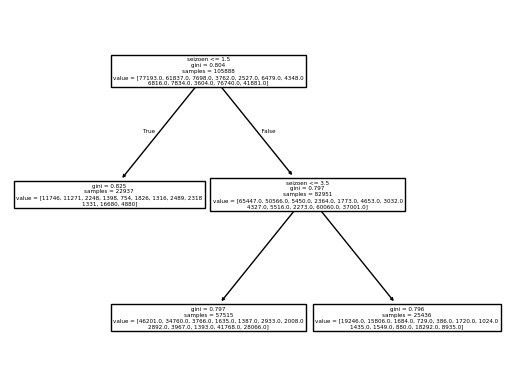

In [131]:
dtree = DecisionTreeClassifier(max_depth= 2)
dtree = dtree.fit(x_train, y_train, sample_weight= weights_train)
tree.plot_tree(dtree, feature_names = xx.columns)
plt.show()

In [132]:
predicted_df = pd.DataFrame(dtree.predict(x_test)).rename(columns={0: 'Predicted_category'})
model_results_frame = pd.concat([y_test.reset_index()['product_category_numeric'], predicted_df], axis=1)
model_results_frame

,product_category_numeric,Predicted_category
0,2,1
1,11,1
2,12,1
3,11,1
4,12,1
...,...,...
18682,2,1
18683,2,1
18684,2,1
18685,12,1


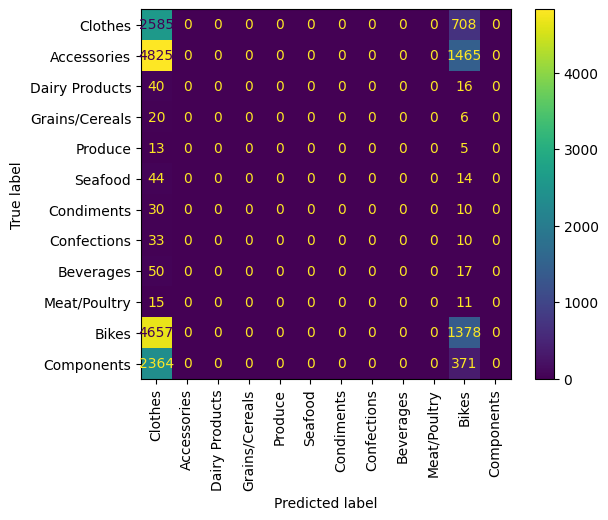

In [133]:
confusion_matrix = metrics.confusion_matrix(model_results_frame['product_category_numeric'], model_results_frame['Predicted_category'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix= confusion_matrix, display_labels = ['Clothes', 'Accessories', 'Dairy Products', 'Grains/Cereals', 'Produce', 'Seafood', 'Condiments', 'Confections', 'Beverages', 'Meat/Poultry', 'Bikes', 'Components' ])
cm_display.plot(xticks_rotation='vertical')
plt.show()